In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import seaborn as sn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# from google.colab import drive
# drive.mount("./gdrive")
# !unzip "/content/gdrive/My Drive/Copy of Copy of Assignment 5 Dataset.zip"

In [0]:
# data_dir = '/content/drive/My Drive/MSDS/SEM2/DL/COV-19'
data_dir = '/content/Assignment 5 Dataset'

In [4]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=validation_transforms)


#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=8, shuffle=True)


print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


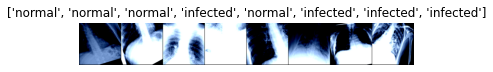

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [6]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
print(vgg16.classifier[3])

Linear(in_features=4096, out_features=4096, bias=True)


In [8]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last fc layers
print(features)

[]


In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [0]:
features.extend([nn.Linear(num_features, ((23*10) + 100))])
features.extend([nn.ReLU(inplace = True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(((23*10) + 100), len(class_names))])

In [11]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.435819: : 1500it [13:46,  1.82it/s]
Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.110221: : 1500it [13:49,  1.81it/s]
Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.080473: : 1500it [13:47,  1.81it/s]
Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.057665: : 1500it [13:52,  1.80it/s]
Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.136559: : 1500it [13:45,  1.82it/s]
Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.118266: : 1500it [13:51,  1.80it/s]
Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.133888: : 1500it [13:48,  1.81it/s]
Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.170447: : 1500it [13:54,  1.80it/s]
Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.487065: : 1500it [13:46,  1.81it/s]
Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.117984: : 1500it [13:48,  1.81it/s]


Finished Training


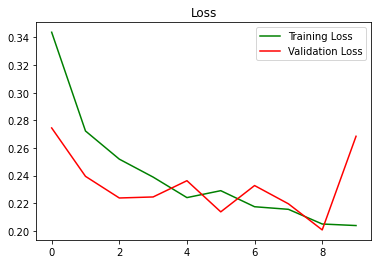

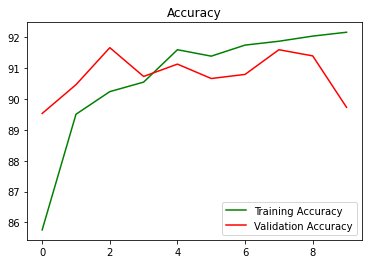

In [13]:
from tqdm import tqdm
vgg16.train()

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device


training_loss_list = list()
validation_loss_list = list()
training_accuracy_list = list()
validation_accuracy_list = list()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.data.item()/ len(trainloader)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
        
    training_loss_list.append(running_loss)    
    training_accuracy_list.append(100 * correct / total)
  
    temp = 0.0
    correct = 0
    total = 0    
    for data in validationloader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = vgg16(inputs)
      loss = criterion(outputs, labels)
      temp = temp + (loss.data.item() / len(validationloader))
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    validation_loss_list.append(temp)
    validation_accuracy_list.append(100 * correct / total)
    

    


    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')

print('Finished Training')
plt.figure(1)
plt.title('Loss')
plt.plot(np.arange(Epochs), training_loss_list, label = "Training Loss", c = 'g')
plt.plot(np.arange(Epochs), validation_loss_list, label = "Validation Loss", c = 'r')
plt.legend(loc='upper right')

plt.figure(2)
plt.title('Accuracy')
plt.plot(np.arange(Epochs), training_accuracy_list, label = "Training Accuracy", c = 'g')
plt.plot(np.arange(Epochs), validation_accuracy_list, label = "Validation Accuracy", c = 'r')
plt.legend(loc='lower right')


plt.show()


In [19]:
#use this cell to load savd model
vgg16.load_state_dict(torch.load('vgg16_FC_Only.pth'))
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
def conf_matrix_output(y_true, y_pred):
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    return tp, tn, fp, fn

In [0]:
def accuracy(y_true, y_pred):
  tp, tn, fp, fn = conf_matrix_output(y_true, y_pred)
  return float((tp+tn)/(tp + tn + fp + fn))*100

In [0]:
def f1_measure(y_true, y_pred):
    
    tp, tn, fp, fn = conf_matrix_output(y_true, y_pred)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    return float(f1)

In [0]:
def confusion_matrix_display(y_true, y_pred):
    
    confmatrix = np.zeros((2,2))

    tp, tn, fp, fn = conf_matrix_output(y_true, y_pred)
    
    confmatrix[0,0] = tn
    confmatrix[0,1] = fp
    confmatrix[1,0] = fn
    confmatrix[1,1] = tp

    df_cm = pd.DataFrame(confmatrix, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    fig = sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}) # font size

    plt.ylabel("Ground Truth")
    plt.xlabel("Prediction")
    plt.show(fig)


In [0]:
y_true = list()
y_pred = list()

for data in testloader:
  images, labels = data
  images = images.to(device)
  y_true.extend(labels.numpy())
  outputs = vgg16(images)
  _, predicted = torch.max(outputs.data, 1)
  y_pred.extend(predicted)
  


y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)


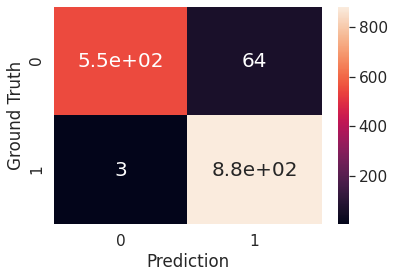

In [69]:
confusion_matrix_display(y_true, y_pred)

In [41]:
f1_measure(y_true, y_pred)

0.9634079337120056

In [76]:
accuracy(y_true, y_pred)

95.53333520889282